In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('HPa', 6, 2)

In [4]:
from loren_frank_data_processing import get_interpolated_position_dataframe
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

In [5]:
from spectral_connectivity import Multitaper, Connectivity
from loren_frank_data_processing import get_LFPs, reshape_to_segments, make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
        epoch_key, drop_level=False)

is_brain_areas = tetrode_info.area.isin(['CA1'])
is_brain_areas = is_brain_areas & (
            tetrode_info.descrip.isin(['riptet']) | tetrode_info.validripple)
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()

LFPs = get_LFPs(tetrode_keys, ANIMALS)

tetrode_info[is_brain_areas].loc[:, ['area', 'depth', 'descrip']]

area    depth descrip
animal day epoch tetrode_number                      
HPa    6   2     1               CA1  [[114]]  riptet
                 4               CA1  [[117]]  riptet
                 5               CA1  [[117]]  riptet
                 6               CA1  [[110]]  riptet
                 7               CA1  [[114]]  riptet

In [6]:
from ripple_detection import Kay_ripple_detector

speed = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, max_distance_from_well=3).speed
not_null = np.all(pd.notnull(LFPs), axis=1) & pd.notnull(speed)

ripple_times = Kay_ripple_detector(
        LFPs.index[not_null], LFPs.values[not_null], speed.values[not_null],
        SAMPLING_FREQUENCY, minimum_duration=pd.Timedelta(milliseconds=15),
        zscore_threshold=3)

In [7]:
ripple_times.head()

,start_time,end_time
ripple_number,,
1,01:09:41.347333,01:09:41.412667
2,01:09:42.290000,01:09:42.345333
3,01:09:42.382000,01:09:42.452000
4,01:09:56.280667,01:09:56.385333
5,01:12:47.588667,01:12:47.773333


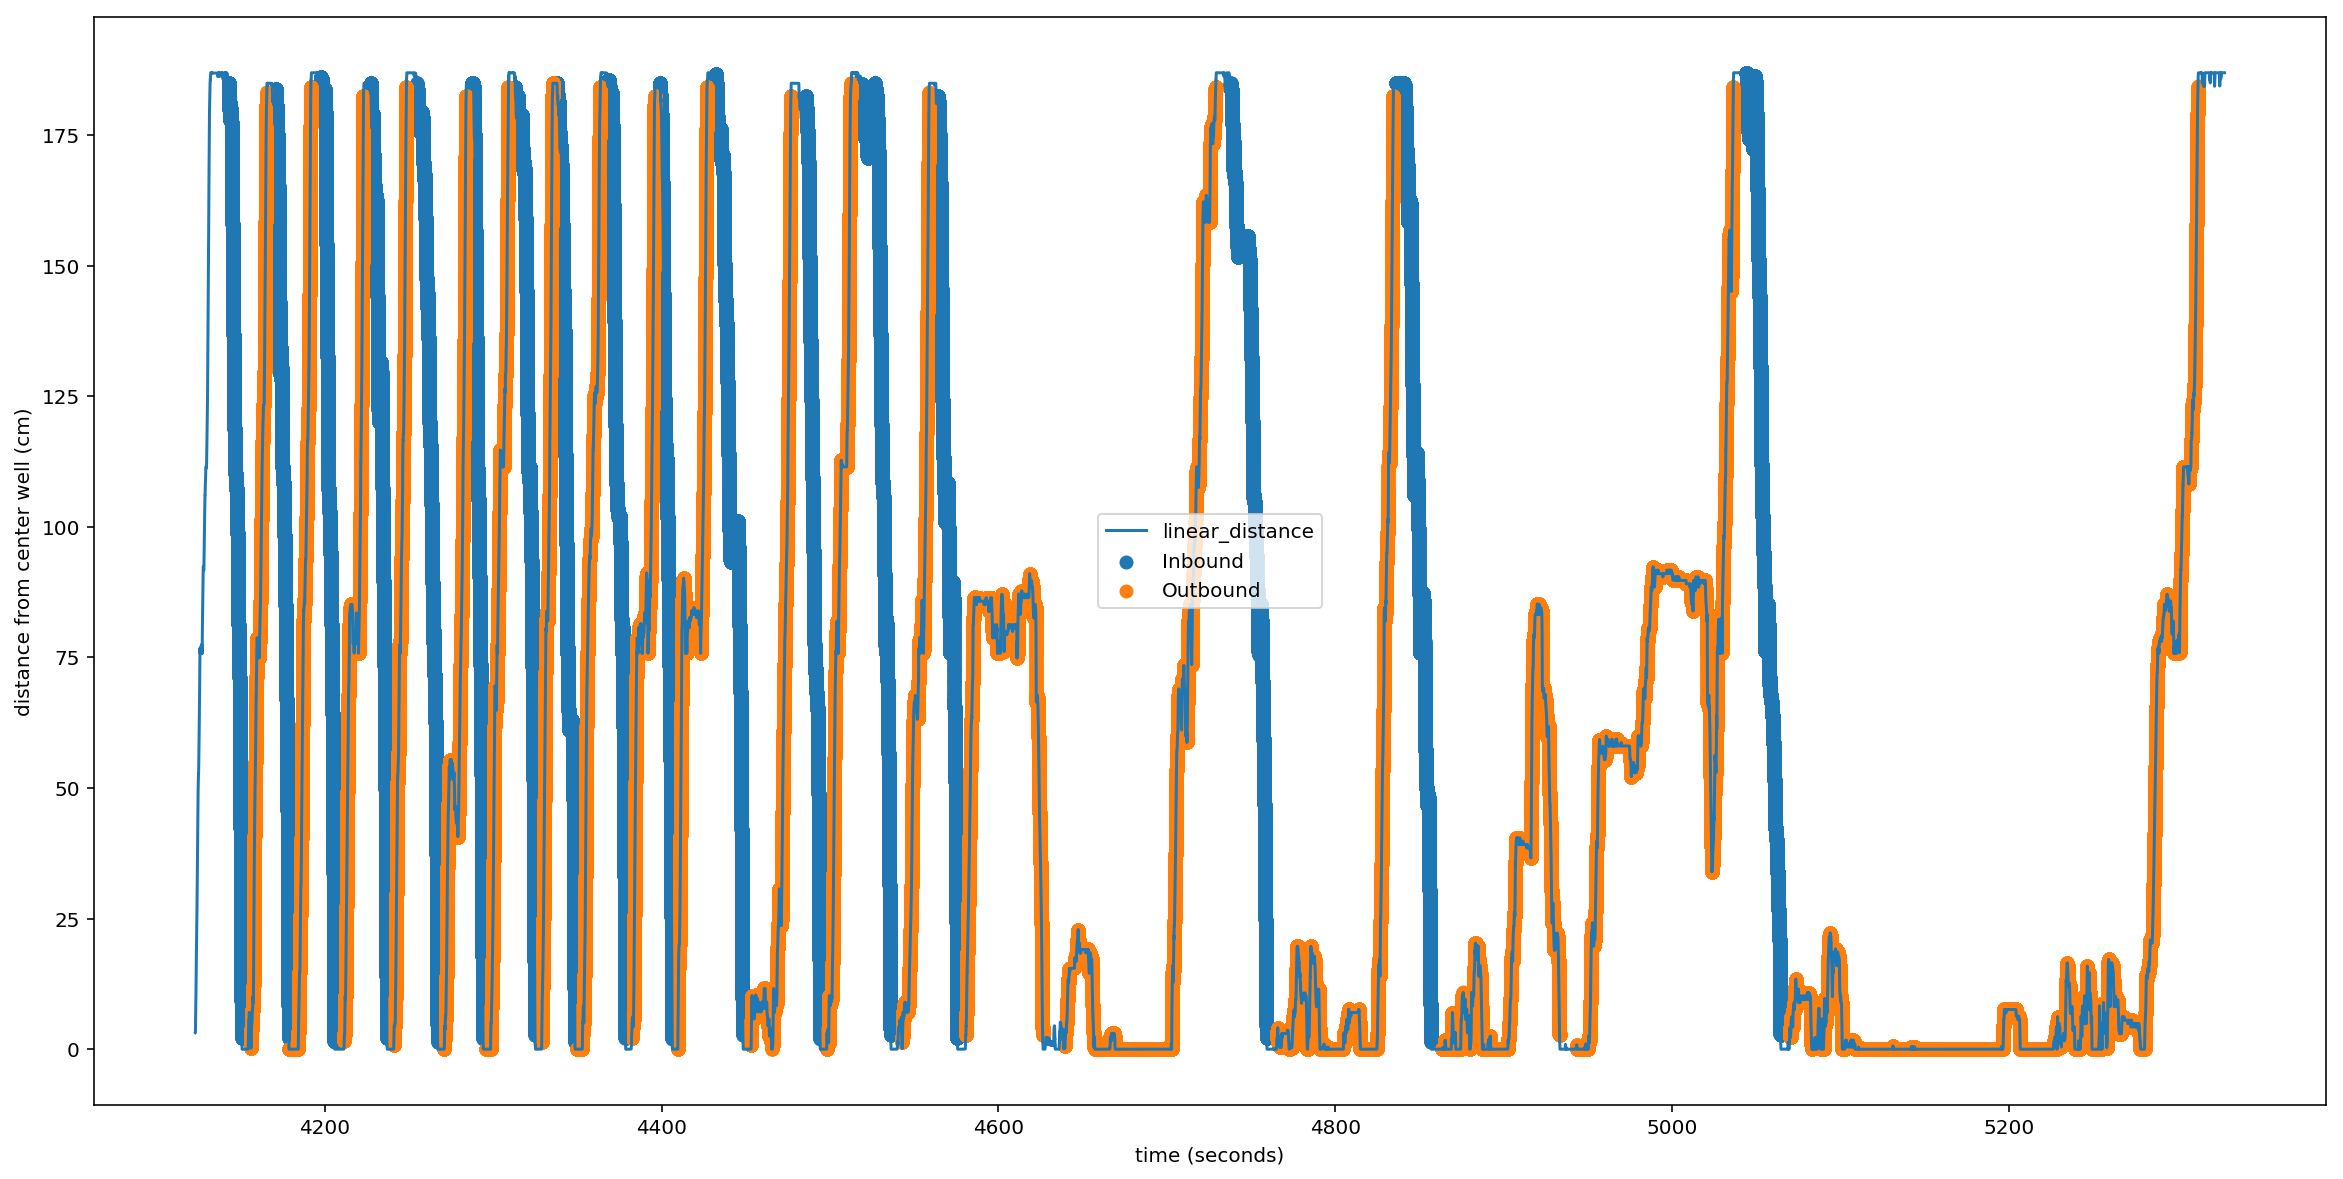

In [8]:
position_info = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, max_distance_from_well=3)

plt.figure(figsize=(20, 10))
plt.plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    plt.scatter(df.index.total_seconds(), df.linear_distance, label=label)

plt.xlabel('time (seconds)')
plt.ylabel('distance from center well (cm)')
plt.legend();

In [9]:
window_offset = (-0.5, 0.5)

ripple_locked_LFPs = reshape_to_segments(
    LFPs, ripple_times,
    window_offset=window_offset, sampling_frequency=SAMPLING_FREQUENCY)
ripple_locked_LFPs.columns = tetrode_info[is_brain_areas].tetrode_id
ripple_locked_LFPs = (ripple_locked_LFPs.to_xarray()
                      .to_array(dim='signals').transpose('time', 'ripple_number', 'signals'))
m = Multitaper(
    ripple_locked_LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=window_offset[0])
c = Connectivity.from_multitaper(m)
ripple_locked_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


In [10]:
m = Multitaper(
    LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=LFPs.index.total_seconds()[0])
c = Connectivity.from_multitaper(m)
power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=4122.992, n_tapers=5)


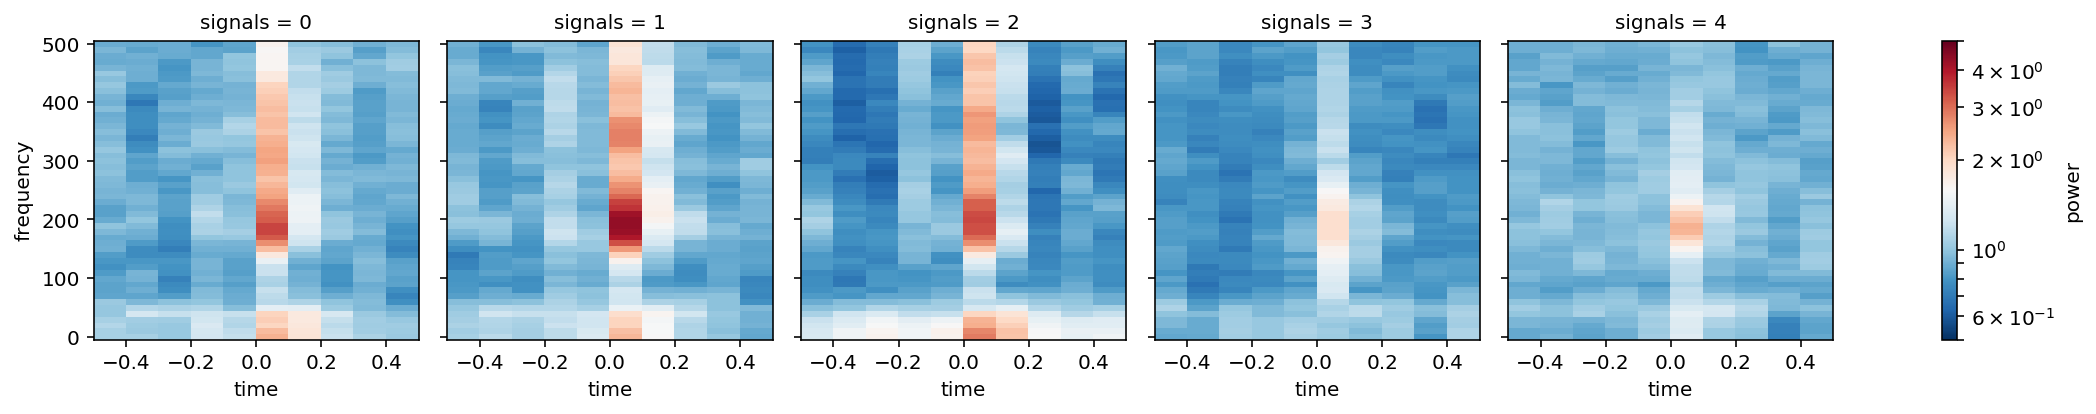

In [11]:
from matplotlib.colors import LogNorm

vmin, vmax = 0.5, 5

(ripple_locked_power / power.mean('time')).sel(frequency=slice(0, 500)).plot(
    x='time', y='frequency', col='signals', col_wrap=5, center=0,
    norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
    cmap='RdBu_r');

In [12]:
ripple_duration = ripple_times.end_time.dt.total_seconds() - ripple_times.start_time.dt.total_seconds()

In [13]:
from ripple_detection.core import filter_ripple_band

ripple_filtered_LFPs = pd.DataFrame(
    np.stack([filter_ripple_band(lfp, SAMPLING_FREQUENCY) for lfp in LFPs.values.T], axis=1),
    index=LFPs.index, columns=tetrode_keys)

ripple_locked_filtered_LFPs = reshape_to_segments(
    ripple_filtered_LFPs, ripple_times, window_offset=window_offset,
    sampling_frequency=SAMPLING_FREQUENCY)

In [14]:
m = Multitaper(LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.020,
                                     time_window_step=0.004,
               time_halfbandwidth_product=1, start_time=LFPs.index.total_seconds()[0])
c = Connectivity.from_multitaper(m)
ripple_power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'),
                            coords=dict(time=pd.TimedeltaIndex(c.time, unit='s'), frequency=c.frequencies), name='power')
ripple_power = ripple_power.sel(frequency=200).reindex(LFPs.index)
ripple_power /= ripple_power.mean('time')
ripple_locked_power = reshape_to_segments(
    ripple_power.drop('frequency').to_dataframe().unstack(), ripple_times, window_offset,
    sampling_frequency=SAMPLING_FREQUENCY)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.004,
           detrend_type='constant', start_time=4122.992, n_tapers=1)


In [15]:
from ipywidgets import interact

ripple_time = ripple_locked_LFPs.get_index('time').total_seconds().values

def plot_lfp(ripple_number=1):
    n_LFPs = LFPs.shape[1]
    fig, axes = plt.subplots(n_LFPs, 3, figsize=(20, 10), sharex=True)
    for ax, lfp in zip(
            axes[:, 0], ripple_locked_LFPs.sel(ripple_number=1).values.T):
        ax.plot(ripple_time, lfp)
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    for ax, lfp in zip(
            axes[:, 1], ripple_locked_filtered_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp, color='orange')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    power_time = ripple_locked_power.loc[ripple_number].index.total_seconds().values
    for ax, p in zip(axes[:, 2], ripple_locked_power.loc[ripple_number].values.T):
        ax.plot(power_time, p, color='purple')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(1, color='black', linestyle='--')

    axes[0, 0].set_title('LFP')
    axes[0, 1].set_title('Bandpass Filtered LFP (150 - 250 Hz)')
    axes[0, 2].set_title('Ripple Power Change');

n_ripples = len(ripple_times)
interact(plot_lfp, ripple_number=(1, n_ripples), continuous_update=False);

interactive(children=(IntSlider(value=1, description='ripple_number', max=69, min=1), Output()), _dom_classes=('widget-interact',))

In [16]:
from loren_frank_data_processing import make_neuron_dataframe, get_spike_indicator_dataframe

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).loc[:, ['area', 'numspikes']].dropna()
neuron_info = neuron_info.loc[neuron_info.numspikes > 0]

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve, gaussian

from loren_frank_data_processing import (get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         reshape_to_segments)


def plot_perievent_raster(neuron_or_tetrode_key, animals, events, tetrode_info,
                          window_offset=(-0.5, 0.5),
                          sampling_frequency=1500, ax=None,
                          **scatter_kwargs):
    '''Plot spike raster relative to an event.

    Parameters
    ----------
    neuron_or_tetrode_key : tuple
    animals : dict of namedtuples
    events : pandas DataFrame, shape (n_events, 2)
    tetrode_info : pandas DataFrame, shape (n_tetrodes, ...)
    window_offset : tuple, optional
    sampling_frequency : tuple, optional
    ax : matplotlib axes, optional
    scatter_kwargs : dict

    Returns
    -------
    ax : matplotlib axes

    '''
    if ax is None:
        ax = plt.gca()
    try:
        spikes = get_spike_indicator_dataframe(neuron_or_tetrode_key, animals)
    except ValueError:
        spikes = ((get_multiunit_indicator_dataframe(
            neuron_or_tetrode_key, animals) > 0).sum(axis=1) > 0) * 1.0
    event_locked_spikes = reshape_to_segments(
        spikes, events, window_offset=window_offset,
        sampling_frequency=sampling_frequency).unstack(level=0).fillna(0)
    time = event_locked_spikes.index.total_seconds()
    spike_index, event_number = np.nonzero(event_locked_spikes.values)

    ax.scatter(time[spike_index], event_number, **scatter_kwargs)
    ax.axvline(0.0, color='black')
    ax.set_title(
        tetrode_info.loc[neuron_or_tetrode_key[:4]].area.upper() + ' - ' +
        str(neuron_or_tetrode_key))
    ax.set_ylabel(events.index.name)
    ax.set_xlabel('time (seconds)')
    ax.set_ylim((0, events.index.max() + 1))
    ax.set_xlim(window_offset)

    ax2 = ax.twinx()
    kde = kernel_density_estimate(
        event_locked_spikes, sampling_frequency, sigma=0.025)
    m = ax2.plot(time, kde[:, 1], color='blue', alpha=0.8)
    ax2.fill_between(time, kde[:, 0], kde[:, 2],
                     color=m[0].get_color(), alpha=0.2)
    ax2.set_ylabel('Firing Rate (spikes / s)')

    return ax


def kernel_density_estimate(
        is_spike, sampling_frequency, sigma=0.025):
    '''The gaussian-smoothed kernel density estimate of firing rate over
    trials.

    Parameters
    ----------
    is_spike : ndarray, shape (n_time, n_trials)
    sampling_frequency : float
    bandwidth : float

    Returns
    -------
    firing_rate : ndarray, shape (n_time,)

    '''
    bandwidth = sigma * sampling_frequency
    n_window_samples = int(bandwidth * 8)
    kernel = gaussian(n_window_samples, bandwidth)[:, np.newaxis]
    density_estimate = convolve(
        is_spike, kernel, mode='same') / kernel.sum()
    n_events = density_estimate.shape[1]
    firing_rate = np.nanmean(density_estimate, axis=1,
                             keepdims=True) * sampling_frequency
    firing_rate_std = (np.nanstd(density_estimate, axis=1, keepdims=True) *
                       sampling_frequency / np.sqrt(n_events))
    ci = np.array([-1.96, 0, 1.96])
    return firing_rate + firing_rate_std * ci


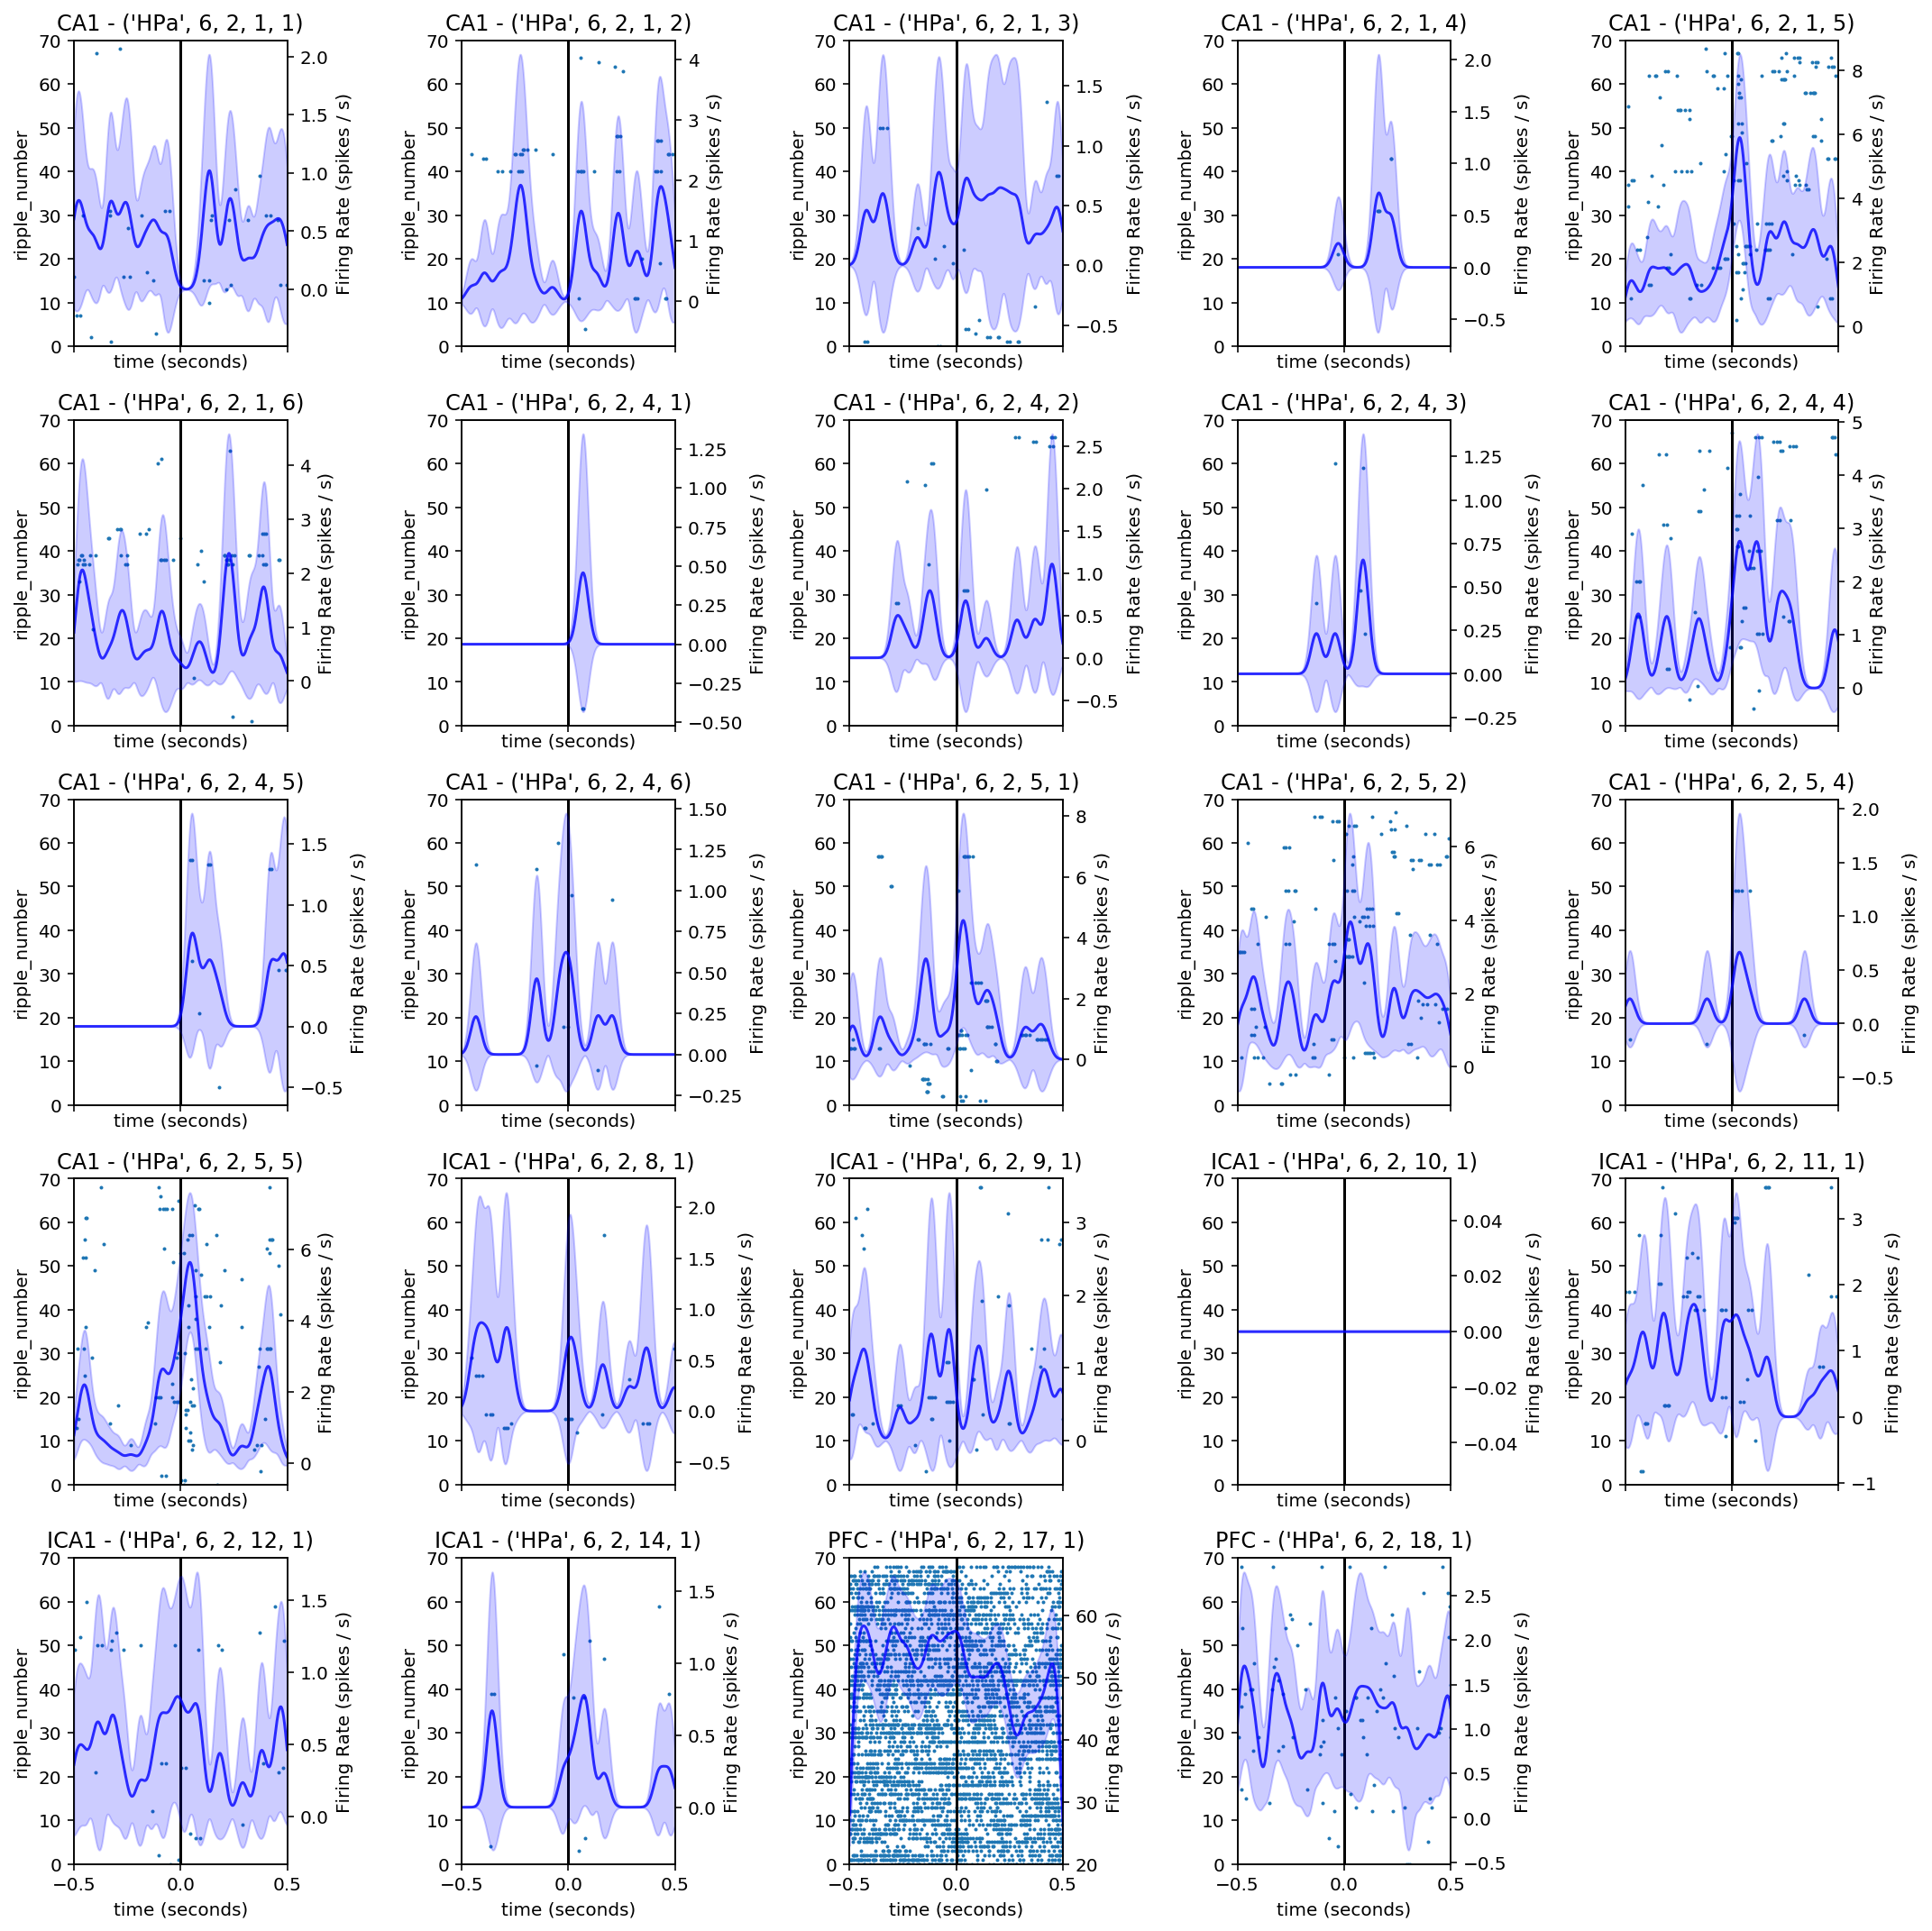

In [18]:
neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

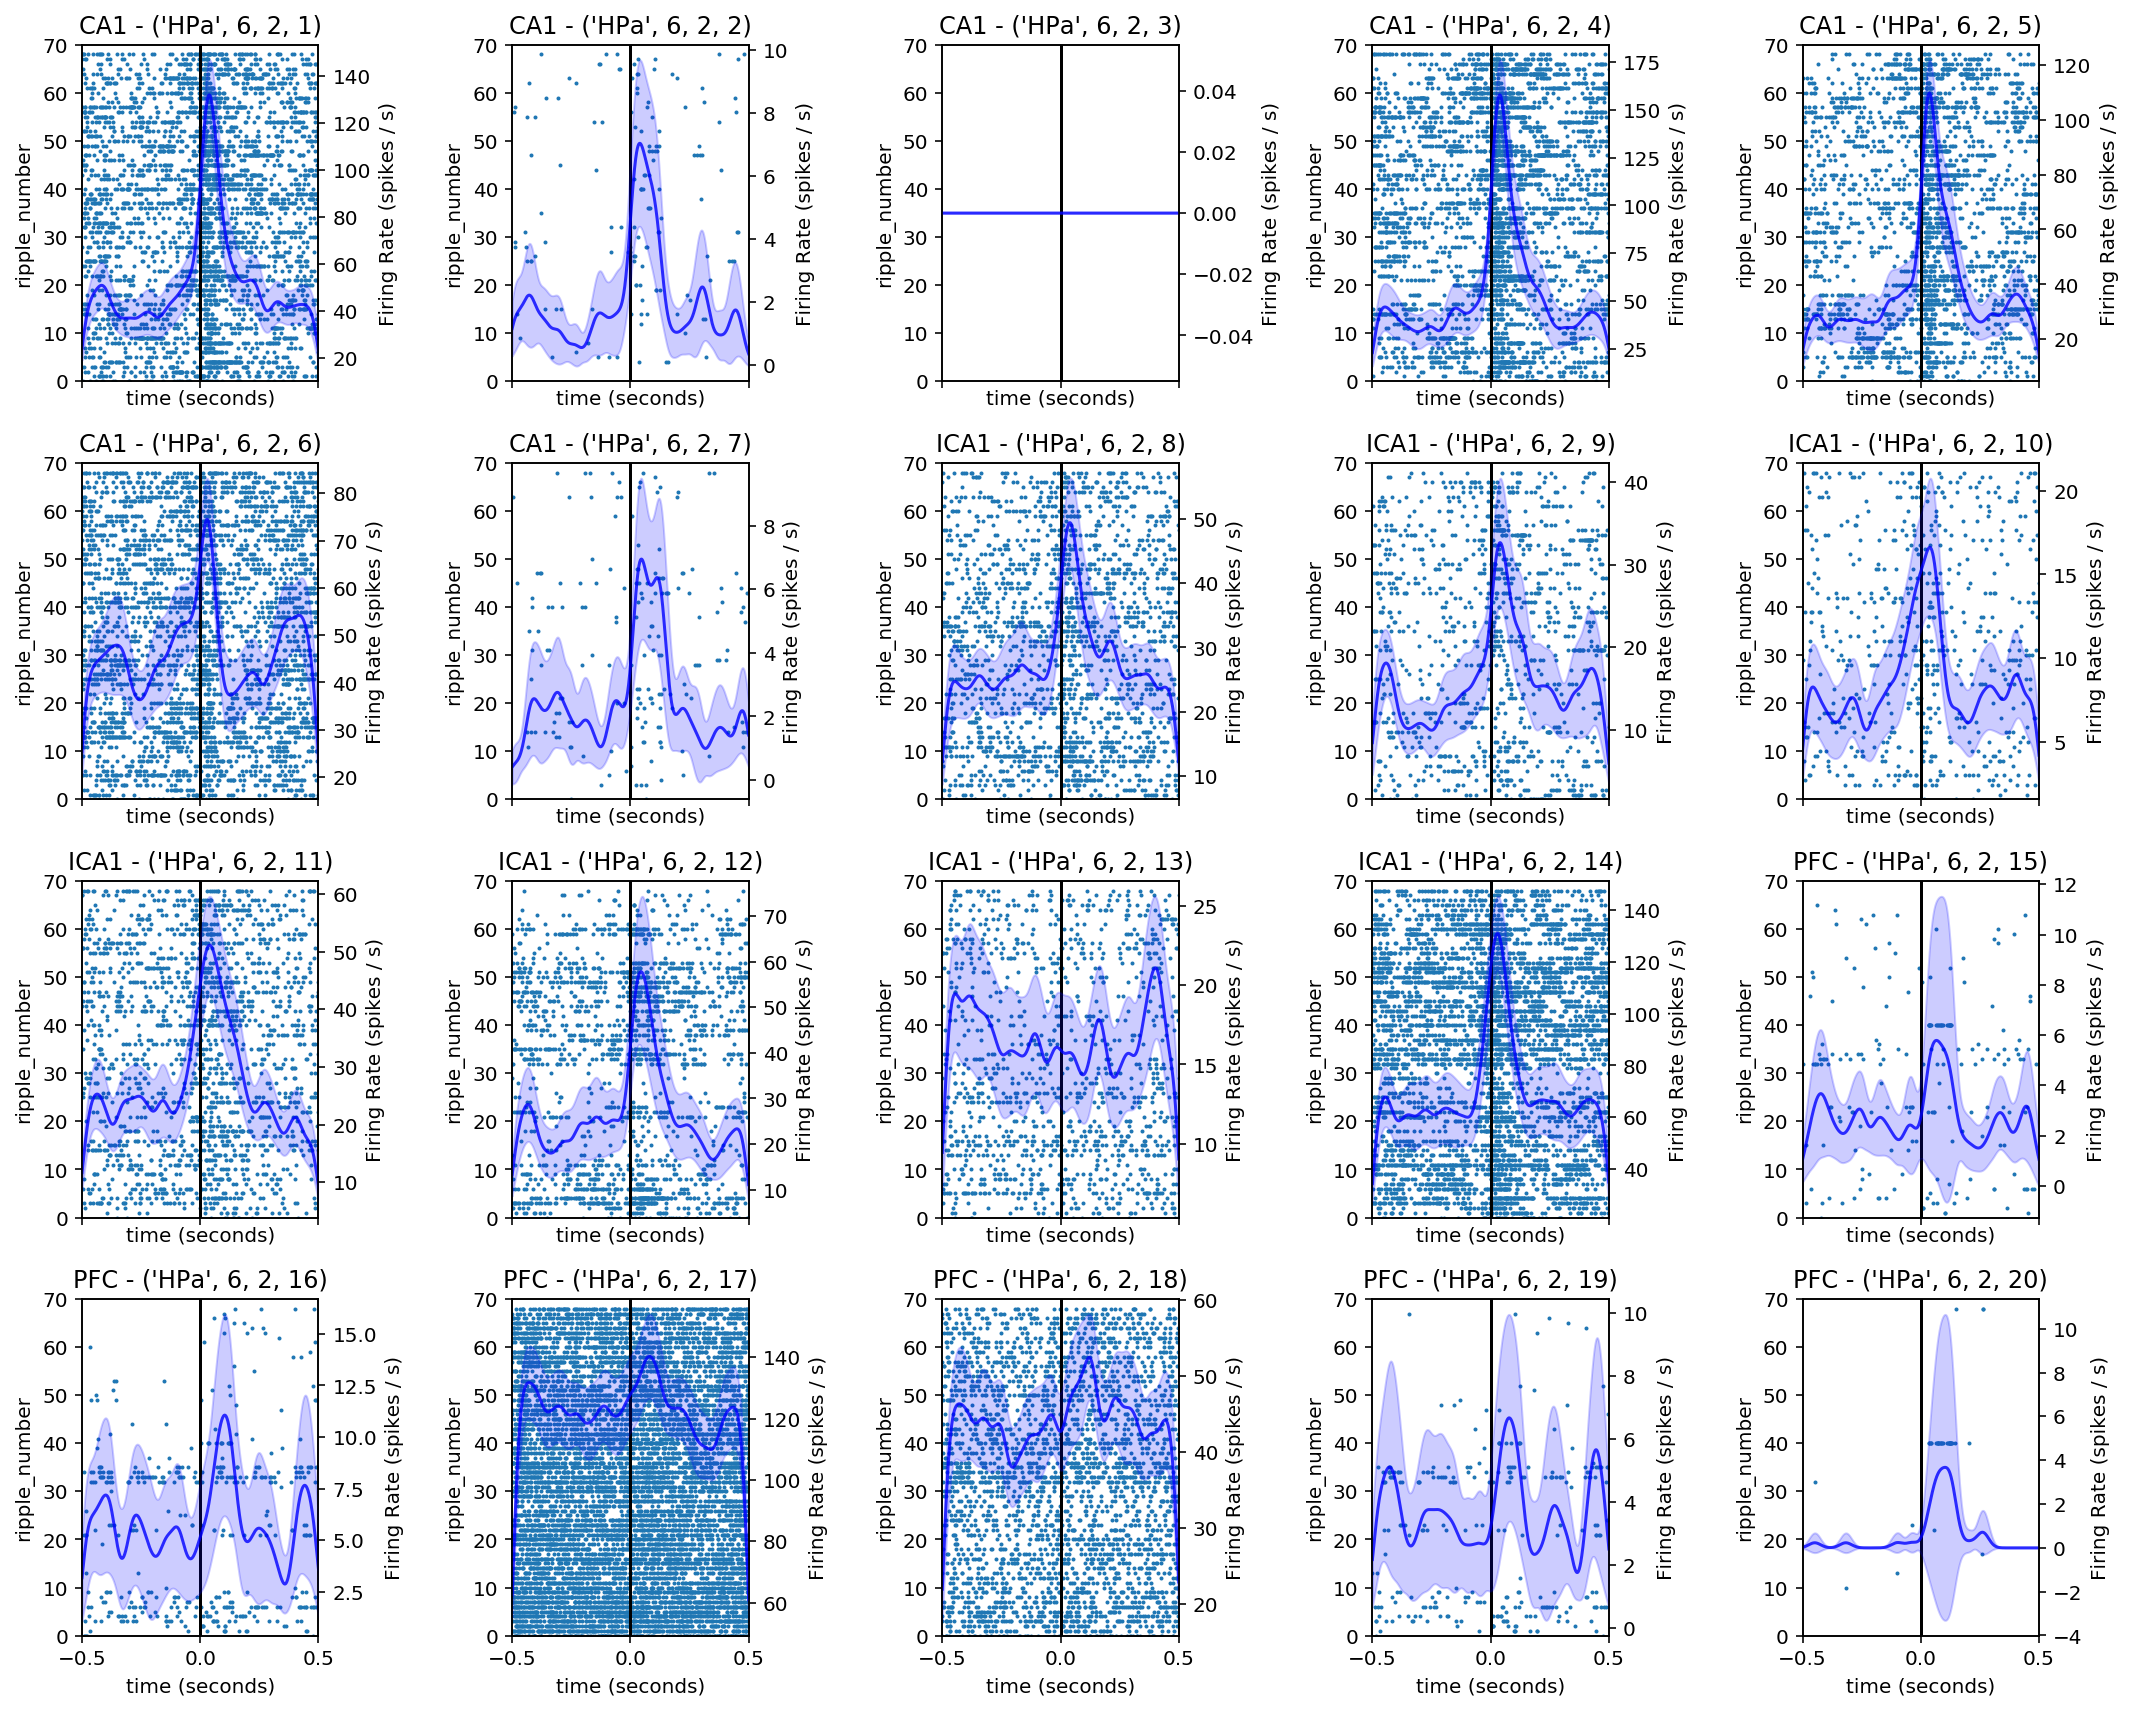

In [19]:
tetrode_keys = tetrode_info.index
n_tetrodes = len(tetrode_keys)

col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), tetrode_keys):
    try:
        plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                              tetrode_info, window_offset=(-0.5, 0.5),
                              ax=ax, s=1)
    except TypeError:
        pass
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')

plt.tight_layout()

In [43]:
from loren_frank_data_processing import (get_interpolated_position_dataframe,
                                         get_LFP_dataframe,
                                         get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe,
                                         reshape_to_segments, save_xarray)
from replay_classification import ClusterlessDecoder, SortedSpikeDecoder

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
brain_areas_tetrodes = tetrode_info[
    tetrode_info.area.isin(['CA1']) &
    (tetrode_info.descrip.isin(['riptet']) | tetrode_info.validripple)]

mark_names = get_multiunit_indicator_dataframe(
    brain_areas_tetrodes.index[0], ANIMALS).columns.tolist()
mark_names = [mark_name for mark_name in mark_names
              if mark_name not in ['x_position', 'y_position']]
marks = [(get_multiunit_indicator_dataframe(tetrode_key, ANIMALS)
      .loc[:, mark_names])
     for tetrode_key in brain_areas_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
     if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
         .shape[0]) != 0]

train_position_info = position_info.query('speed > 4')

training_marks = np.stack([
    tetrode_marks.loc[train_position_info.index, mark_names]
    for tetrode_marks in marks], axis=0)

n_position_bins = 61
place_std_deviation = 20
mark_std_deviation = 20

decoder = ClusterlessDecoder(
        train_position_info.linear_distance.values,
        train_position_info.task.values,
        training_marks,
        n_position_bins=n_position_bins,
        place_std_deviation=place_std_deviation,
        mark_std_deviation=mark_std_deviation,
        replay_speedup_factor=16,
    ).fit()

display(brain_areas_tetrodes)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


area    depth descrip hemisphere  maxcell  \
animal day epoch tetrode_number                                             
HPa    6   2     1               CA1  [[114]]  riptet        NaN      NaN   
                 4               CA1  [[117]]  riptet        NaN      NaN   
                 5               CA1  [[117]]  riptet        NaN      NaN   
                 6               CA1  [[110]]  riptet        NaN      NaN   
                 7               CA1  [[114]]  riptet        NaN      NaN   

                                 nearCA2  numcells  representative subarea  \
animal day epoch tetrode_number                                              
HPa    6   2     1                   NaN       7.0             NaN     NaN   
                 4                   NaN       8.0             NaN     NaN   
                 5                   NaN       5.0             NaN     NaN   
                 6                   NaN       0.0             NaN     NaN   
                 7                   NaN       0.0             NaN     NaN   

                                    tetrode_id  validripple  
animal day epoch tetrode_number                              
HPa    6   2     1               HPa_06_02_001          NaN  
                 4               HPa_06_02_004          NaN  
                 5               HPa_06_02_005          NaN  
                 6               HPa_06_02_006          NaN  
                 7               HPa_06_02_007          NaN

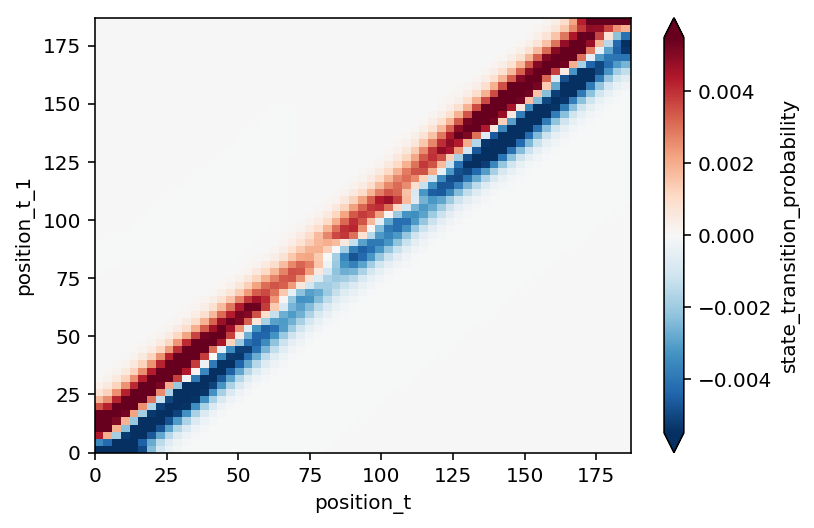

In [44]:
(decoder.state_transition_matrix.sel(state='Inbound-Forward') -
 decoder.state_transition_matrix.sel(state='Outbound-Forward')).plot(x='position_t', y='position_t_1', robust=True)

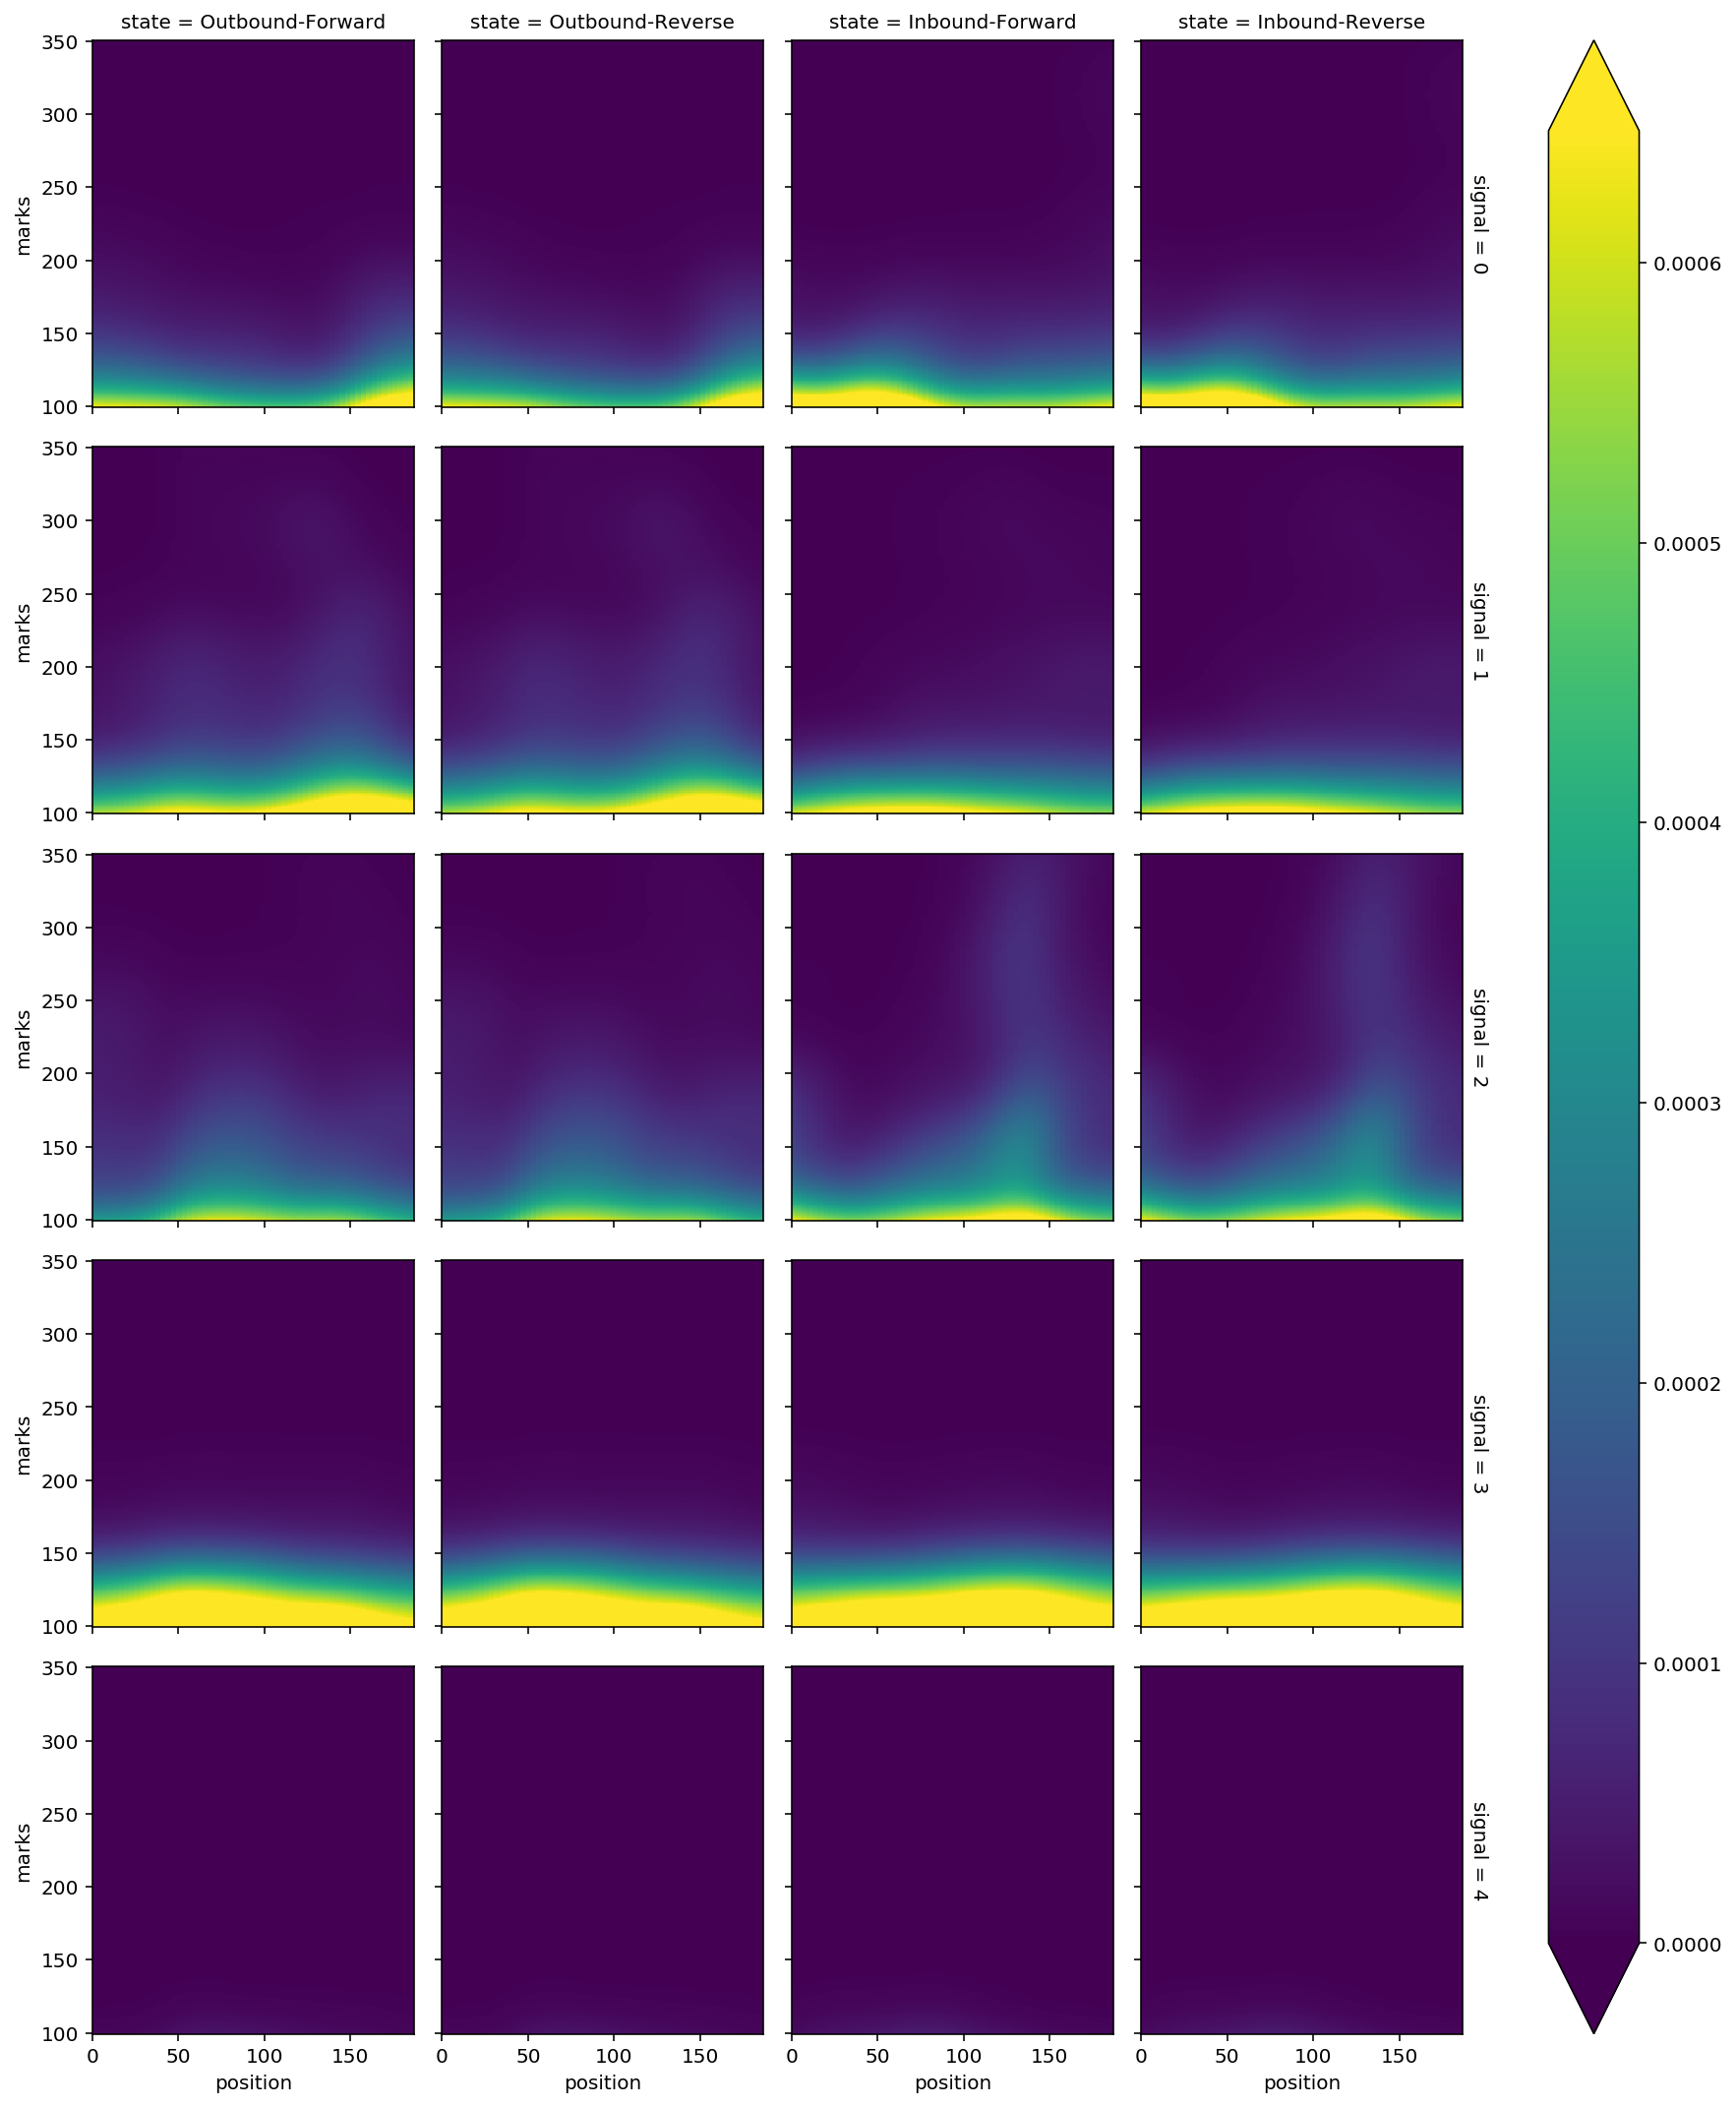

In [45]:
decoder.plot_observation_model()

In [46]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(marks, ripple_times, SAMPLING_FREQUENCY)
results = [decoder.predict(ripple_marks, time.total_seconds())
           for ripple_marks, time in test_marks]

In [47]:
from src.analysis import summarize_replay_results

(replay_info, decision_state_probability,
            posterior_density) = summarize_replay_results(
        results, ripple_times, position_info, epoch_key)

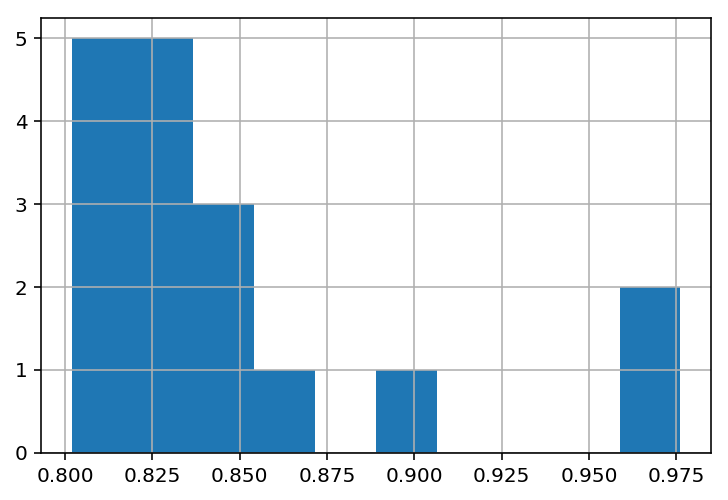

In [48]:
replay_info.predicted_state_probability.hist()

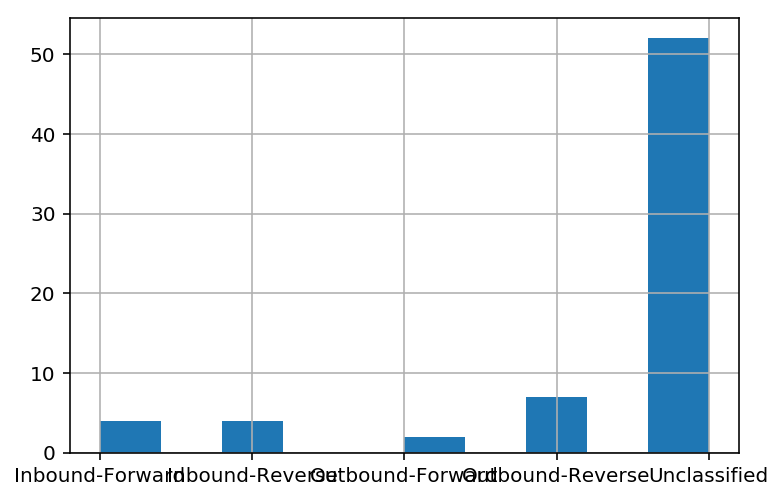

In [49]:
replay_info.predicted_state.hist()

In [50]:
def plot_posterior(ripple_number):
    g = posterior_density.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
    rat_position = replay_info.loc[ripple_number].linear_distance
    for ax in g.axes.ravel():
        ax.axhline(rat_position, color='white', linestyle='--', linewidth=3)
    plt.figure();
    state = (decision_state_probability.sel(concat_dim=ripple_number)
     .dropna('time').drop('concat_dim').to_dataframe().unstack(level=0))
    state.columns = state.columns.droplevel()
    state.plot();
    plt.figure();
    plt.plot(position_info.x_position.values, position_info.y_position.values)
    plt.scatter(replay_info.loc[ripple_number].x_position,
                replay_info.loc[ripple_number].y_position, color='red', zorder=100, s=100)
    plot_lfp(ripple_number);
interact(plot_posterior, ripple_number=(1, len(ripple_times)-1), continuous_update=False);

interactive(children=(IntSlider(value=34, description='ripple_number', max=68, min=1), Output()), _dom_classes=('widget-interact',))

In [33]:
neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = pd.merge(
    neuron_info.reset_index('neuron_number'), tetrode_info.loc[:, ['numcells', 'validripple', 'descrip']],
    right_index=True, left_index=True).set_index('neuron_number', append=True)
neuron_info = neuron_info[
    neuron_info.area.isin(['CA1']) &
    (neuron_info.descrip.isin(['riptet']) | neuron_info.validripple) & neuron_info.numspikes > 0]
spikes_data = [get_spike_indicator_dataframe(neuron_key, ANIMALS)
               for neuron_key in neuron_info.index]

train_spikes_data = [spikes_datum[position_info.speed > 4]
                     for spikes_datum in spikes_data]
decoder_sortedspikes = SortedSpikeDecoder(
    position=train_position_info.linear_distance.values,
    spikes=np.stack(train_spikes_data, axis=0),
    trajectory_direction=train_position_info.task.values,
    n_position_bins=n_position_bins,
    replay_speedup_factor=16,
).fit()

display(neuron_info)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


area       csi hemisphere  \
animal day epoch tetrode_number neuron_number                             
HPa    6   2     1              1              CA1  0.004049        NaN   
                                2              CA1  0.117225        NaN   
                                3              CA1  0.042945        NaN   
                                4              CA1  0.104167        NaN   
                                5              CA1  0.091950        NaN   
                                6              CA1  0.093514        NaN   
                 4              1              CA1  0.206349        NaN   
                                2              CA1  0.088235        NaN   
                                3              CA1  0.023166        NaN   
                                4              CA1  0.151860        NaN   
                                5              CA1  0.154930        NaN   
                                6              CA1  0.047794        NaN   
                 5              1              CA1  0.267584        NaN   
                                2              CA1  0.097618        NaN   
                                4              CA1  0.195122        NaN   
                                5              CA1  0.069979        NaN   

                                               meanrate  nearCA2  \
animal day epoch tetrode_number neuron_number                      
HPa    6   2     1              1              0.409959      NaN   
                                2              0.346888      NaN   
                                3              0.405809      NaN   
                                4              0.159336      NaN   
                                5              2.247303      NaN   
                                6              0.550207      NaN   
                 4              1              0.156846      NaN   
                                2              0.112863      NaN   
                                3              0.214938      NaN   
                                4              1.092946      NaN   
                                5              0.235685      NaN   
                                6              0.451452      NaN   
                 5              1              0.542739      NaN   
                                2              2.473859      NaN   
                                4              0.544398      NaN   
                                5              2.004149      NaN   

                                                       neuron_id  numspikes  \
animal day epoch tetrode_number neuron_number                                 
HPa    6   2     1              1              HPa_06_02_001_001      494.0   
                                2              HPa_06_02_001_002      418.0   
                                3              HPa_06_02_001_003      489.0   
                                4              HPa_06_02_001_004      192.0   
                                5              HPa_06_02_001_005     2708.0   
                                6              HPa_06_02_001_006      663.0   
                 4              1              HPa_06_02_004_001      189.0   
                                2              HPa_06_02_004_002      136.0   
                                3              HPa_06_02_004_003      259.0   
                                4              HPa_06_02_004_004     1317.0   
                                5              HPa_06_02_004_005      284.0   
                                6              HPa_06_02_004_006      544.0   
                 5              1              HPa_06_02_005_001      654.0   
                                2              HPa_06_02_005_002     2981.0   
                                4              HPa_06_02_005_004      656.0   
                                5              HPa_06_02_005_005     2415.0   

                                               

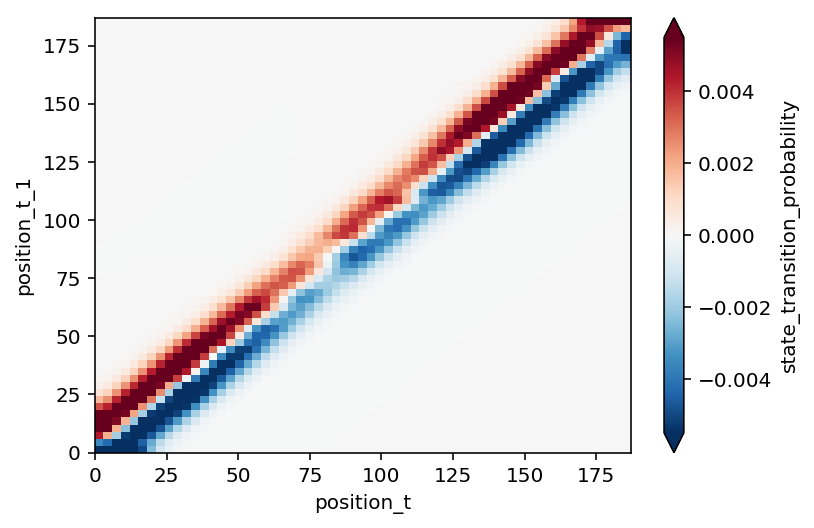

In [34]:
(decoder_sortedspikes.state_transition_matrix.sel(state='Inbound-Forward') -
 decoder_sortedspikes.state_transition_matrix.sel(state='Outbound-Forward')).plot(x='position_t', y='position_t_1', robust=True)

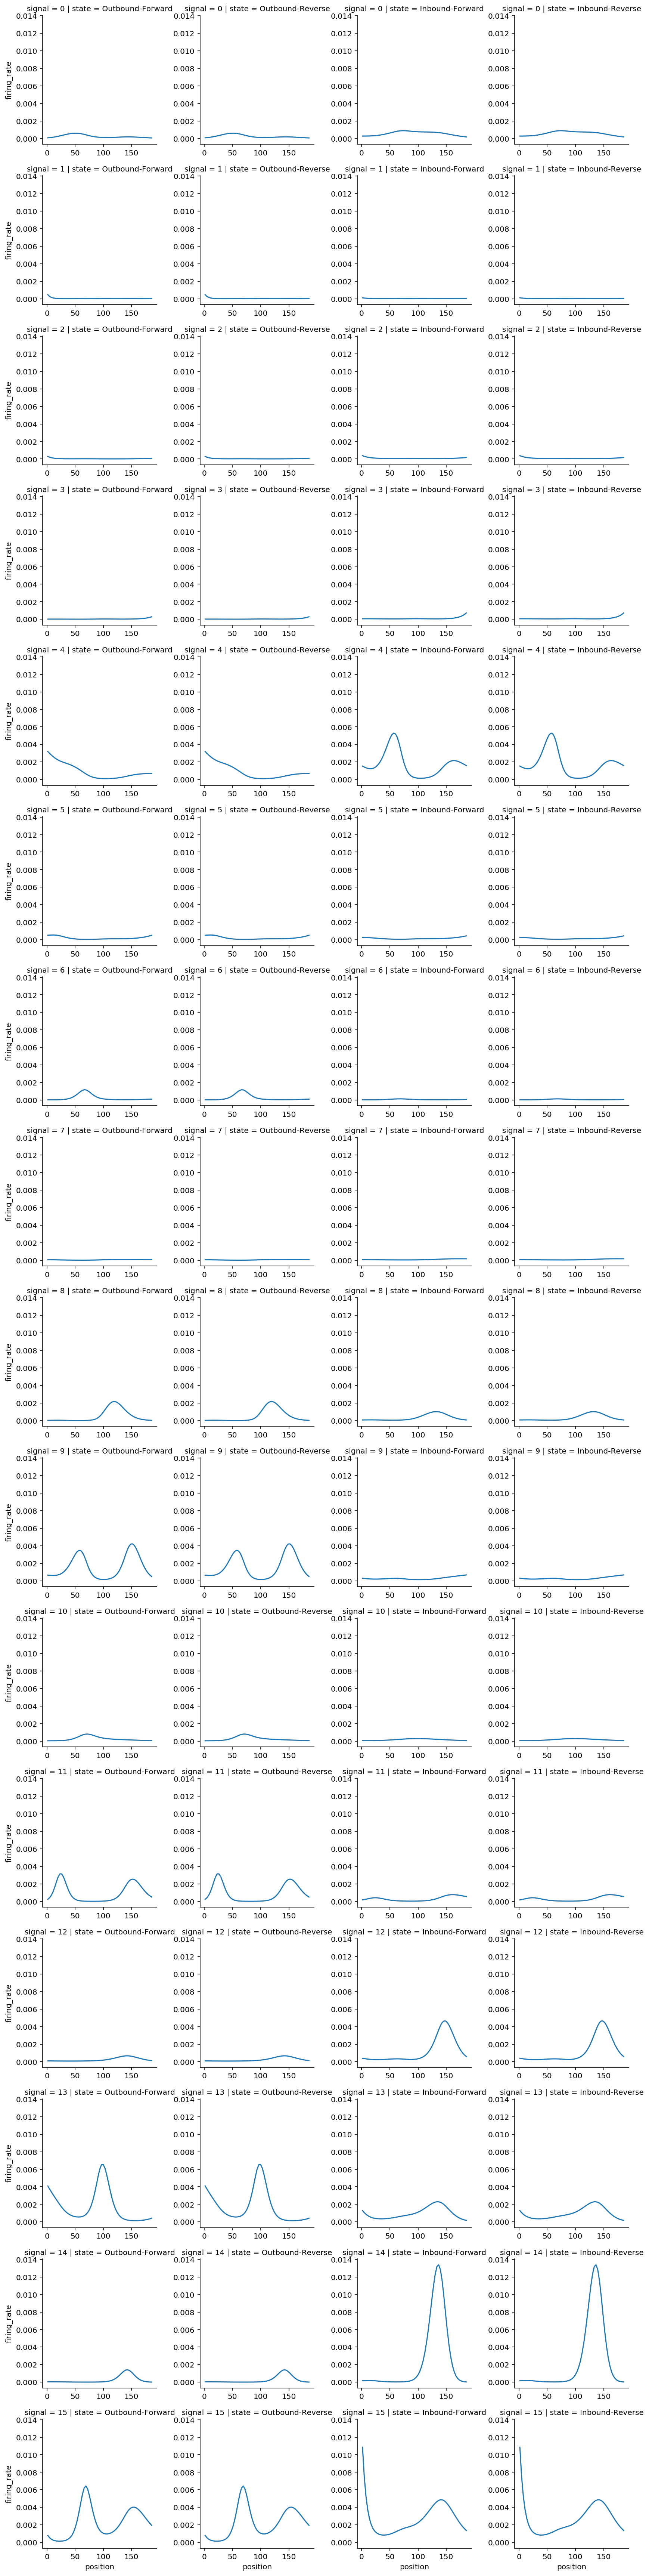

In [35]:
decoder_sortedspikes.plot_observation_model()

In [36]:
def _get_ripple_spikes(spikes_data, ripple_times, sampling_frequency):
    '''Given the ripple times, extract the spikes within the ripple
    '''
    spike_ripples = [reshape_to_segments(
        spikes_datum, ripple_times, axis=0, sampling_frequency=sampling_frequency)
        for spikes_datum in spikes_data]

    return [
        (np.stack([df.loc[ripple_number, :].values
                   for df in spike_ripples], axis=0).squeeze(),
         spike_ripples[0].loc[ripple_number, :].index.get_level_values('time'))
        for ripple_number in ripple_times.index]

test_spikes = _get_ripple_spikes(spikes_data, ripple_times, SAMPLING_FREQUENCY)
results_sortedspikes = [decoder_sortedspikes.predict(ripple_spikes, time.total_seconds())
           for ripple_spikes, time in test_spikes]

In [37]:
from src.analysis import summarize_replay_results

(replay_info_sortedspikes, decision_state_probability_sortedspikes,
            posterior_density_sortedspikes) = summarize_replay_results(
        results_sortedspikes, ripple_times, position_info, epoch_key)

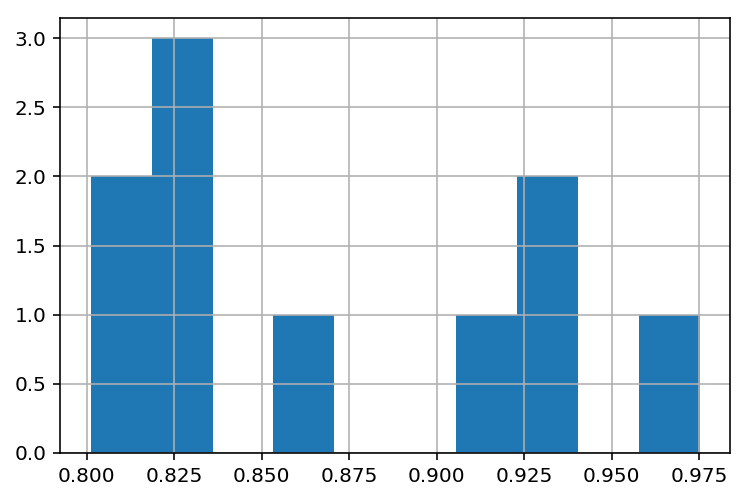

In [38]:
replay_info_sortedspikes.predicted_state_probability.hist()

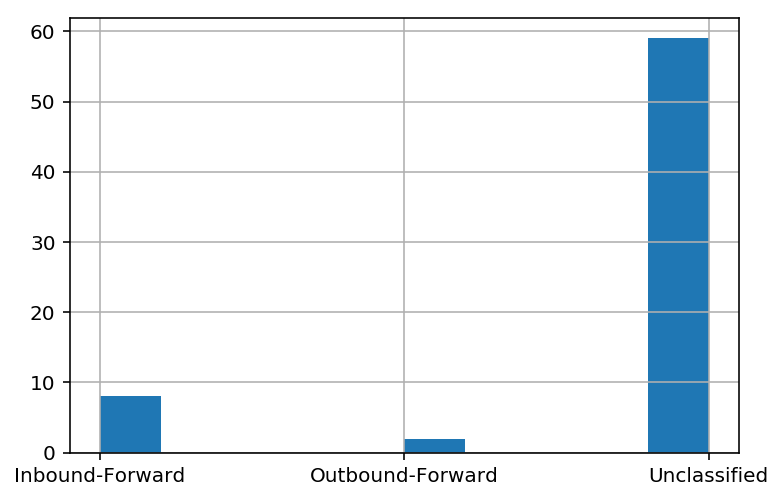

In [39]:
replay_info_sortedspikes.predicted_state.hist()

In [41]:
def plot_posterior_sortedspikes(ripple_number):
    g = posterior_density_sortedspikes.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
    rat_position = replay_info_sortedspikes.loc[ripple_number].linear_distance
    for ax in g.axes.ravel():
        ax.axhline(rat_position, color='white', linestyle='--', linewidth=3)
    plt.figure();
    state = (decision_state_probability_sortedspikes.sel(concat_dim=ripple_number)
     .dropna('time').drop('concat_dim').to_dataframe().unstack(level=0))
    state.columns = state.columns.droplevel()
    state.plot();
    plt.figure();
    plt.plot(position_info.x_position.values, position_info.y_position.values)
    plt.scatter(replay_info_sortedspikes.loc[ripple_number].x_position,
                replay_info_sortedspikes.loc[ripple_number].y_position, color='red', zorder=100, s=100)
    plot_lfp(ripple_number);
interact(plot_posterior_sortedspikes, ripple_number=(1, len(ripple_times)-1), continuous_update=False);

interactive(children=(IntSlider(value=34, description='ripple_number', max=68, min=1), Output()), _dom_classes=('widget-interact',))